# Approach

This notebook describes a linear account of my thinking process in solving the exercise. Throughout the document, I will frequentely present lists of facts that I have established, and assumptions I made in order to proceed.

By keeping track of the fact list, I build up an understanding of how things work. And the items in the assumptions, will eventually be moved to the fact list, replaced with new ones, or be discarded.These two list are decimal numbered for easy reference.


## 1 Exploring Qiskit 
### 1.1 Read through the background theory

The first thing I did was to explore the Hydrogen example given in the notebook. Personally, I am more of a Python programmer then a Quantum chemist. Hence, I find the python codes easier to understand then the technical blurb in the theory section. So, although I did read the theory section, I did not gain too much useful information.





#### fact:
nil
#### assumption:
nil

### 1.2 Exploring the code

The first piece of the code is to specify the $H_2$ molecure and obtain the driver. From reading the code, the first thing I notice is that I need the `qmolecule` object returned from executing `driver.run()`

This is where being familier with Jupyter helps. In jupyter notebook, a very helpful command is the `?` and `??` applied to objects, function, or modules. This will popup a panel at the bottom of the notebook showing the docstring `?`, and the source code `??` from the code in the current system. 


In [5]:
## this is just to execute the example given so that the ? and ?? has some objects to work on
from qiskit_nature.drivers import PySCFDriver
molecule = "H .0 .0 .0; H .0 .0 0.739"
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

Try `shift-Enter` in the following cell to see this feature in operation.

In [12]:
qmolecule?

In [10]:
driver.run?

In [11]:
PySCFDriver?

Now, we have obtained some information about the code:

fact:
1. PySCDFDriver have additional parameters that can be tuned. 
2. qmolecule contains properties of the molecule.

For tutorial question 1, I had a quick look at the qmolecule object with `??` and the information can be infered from reading the source code and comment of the __init__ function.

In [13]:
qmolecule??

Note: From this point onwards, I am only going to point out the object that I have explored, and the facts I have obtained by source code diving without presenting the details. Just to make the descriptiuon short.

**Aside:** In the next cell, I am going to load all the imports that are used through out the exercise so that everything is made avaliable in this notebook.

In [14]:
from qiskit_nature.drivers import PySCFDriver
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers import FreezeCoreTransformer
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_nature.circuit.library import HartreeFock
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD
from qiskit import Aer
from qiskit.compiler import transpile
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 
from qiskit.algorithms import VQE
from IPython.display import display, clear_output
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller   

Next, the function to explore are the `ElectronicStructureProblem` and `second_q_ops`

In [16]:
ElectronicStructureProblem??

fact:
1. PySCDFDriver have additional parameters that can be tuned.
2. qmolecule contains properties of the molecule.
3. ElectronicsStructureProblem takes a second parameter of the class `qiskit_nature.transformers.base_transformer.BaseTransformer`
4. second_q_ops returns a list and it appears that the code only interested in the first element. (from the comment in the source code, the first in the list is 'electronic operator'

Now, we come to the qubit converter section. Which echos some of the confusing terminologies read in the theory section. These are mappers and converters.

#### Assumption:
1. converter and mappers are important parameter to tune.

Firstly, lets check out the `ParityMapper`, and then the other two that are in the code but not used.

In [18]:
ParityMapper?

In [19]:
JordanWignerMapper?

In [20]:
BravyiKitaevMapper?

When I go through the documentation, I took note that these all takes a parameter named `allows_two_qubit_reduction` but I did not pay too much attention till later.

In [21]:
QubitConverter?

When I get to look into the document for the converter, I noted that there is another `two_qubit_reduction` parameter and another `z2symmetry_reduction`.

Hindsight is always great, but again I just take note and wanting to get to the VQE and the optimizer.

Next, I did the same with `HartreeFock` function and also note that how the property of the molecule are used to provide the parameters for some of these function.

In [22]:
HartreeFock?

#### ANSATZ
When I read this part of the code, I immediately assumed that this is the place where all the tuning parameters are. (hindsight: Mapper and converter is where all the tuning happens initially) In summary, these are the additional information obtained.

fact:
1. PySCDFDriver have additional parameters that can be tuned.
2. qmolecule contains properties of the molecule.
3. ElectronicsStructureProblem takes a second parameter of the class `qiskit_nature.transformers.base_transformer.BaseTransformer`
4. second_q_ops returns a list and it appears that the code only interested in the first element. (from the comment in the source code, the first in the list is 'electronic operator'
5. TwoLocal have a lot of parameters with many combinations. Remember to look at the document later.
6. UCCSD, SUCCD, PUCCD are all related, but they have a lot less parameter to tune.

In [25]:
TwoLocal?

In [26]:
UCCSD?

In [28]:
SUCCD?

In [30]:
PUCCD?

I also noted that the UCCSD, SUCCD. PUCCD are all subclass of `UCC`. To me, all of these acronymes do not mean much, but from experience with python, I know that there may be parameters hidden in the parent class. So, I want to find `UCC` and see what I can find. 

In [31]:
from qiskit_nature.circuit.library import UCC

In [32]:
UCC?

Read this document and I think to myself, jackpot. The plan of attack start to become clear. 
1. create the equivelent code for the LiH molecule. 
2. investigate the set of parameters found hidden in UCC, and start to optimise.

<font color='red'>I did not need to explore these parameters at the end. But knowing what's avaliable for tuning is always good.</font> 

By now, I have spend several hours exploring the code, and finally got to some more familiar terrotory. The four optimizers. Firstly, my attention was drawn to the comment that I might need to change the parameters. BUT, from my experience, these are local optimisers, and there is not much tuning one can do except to reduce the tolerence, or the maximum evaluation or iterations.

Looking into the code, they don't look special and probably comes from the scipy package.

Instead of the default `COBLA`, I switched it to `SLSQP` mostly out of personal familiarity with that algorithm.

In [36]:
# check out the document of the different optimisation algoriths if you need to
#COBYLA?
SLSQP?

Next, we were introduced with another new function `GroundStateEigensolver`. From the documentation, it takes the converter as input, and what appears to be a generic Eigen Solver. 

In [38]:
GroundStateEigensolver??

In [40]:
solver = NumPyMinimumEigensolverFactory()
solver?

Note: usually, sufficient information can be obtained by appending `?` to the end of a function. In the above case, when the function returns a python object, it is more infromative to realise the object and perform the `?` on the object itself to get the information.

Finally, we got to the section of code that execute the `VQE`, and the required argument list do not contain anything that looks like a tuning parameter.

In [41]:
VQE?

Tutorial Question Two asked us to explore all the tunerable parameters and provide the ansatz. Which I skipped.

## Final Challenge

### Review known information

In [46]:
import qiskit_nature
qiskit_nature.transformers??

In [29]:
PUCCD?

backend = Aer.get_backend('statevector_simulator')
experiment_name = 'LiH'

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result


{'pass': True, 'optimizer': 'SLSQP', 'mapping': 'ParityMapper', 'ansatz': 'QuantumCircuit', 'rotation blocks': None, 'entanglement_blocks': None, 'entanglement': None, 'repetitions': None, 'skip_final_rotation_layer': None, 'energy (Ha)': -1.0863669545487198, 'error (mHa)': 2.339061186023228, '# of parameters': 16, 'final parameters': array([ 1.00074397e-02,  1.43050536e-01,  1.07739840e-05,  5.25675323e-02,
        3.13162454e+00,  3.19040562e+00,  4.44288366e-01,  1.00052453e-02,
        1.00023356e-02,  1.00013432e-02,  2.52352162e-01, -5.66658827e-03,
       -3.14157233e+00, -2.69653213e+00, -6.87063637e-02,  7.43705286e-02]), '# of evaluations': 905, 'optimizer time': 4.5313210419990355, '# of qubits': 4, '# of CNOTs': 3, 'score': 3}


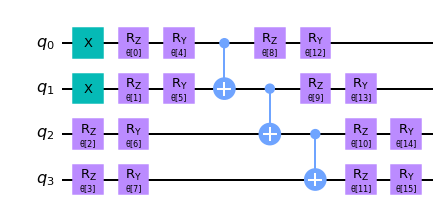

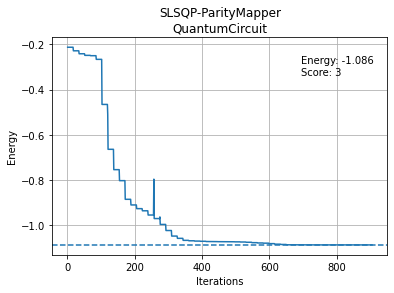

In [15]:
def run(experiment_name='LiH', show_plot = True, save_plot=False):
    if experiment_name == 'LiH':
        molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
    elif experiment_name == 'H2':
        molecule = "H .0 .0 .0; H .0 .0 0.739"
    freeze = True # True
    orbital_removal = [3,4]
    mapper_type = "ParityMapper"# 'ParityMapper' # 'JordanWignerMapper', 'BravyiKitaevMapper', 'ParityMapper'
    # Choose the ansatz
    ansatz_type = "Custom" # "TwoLocal", "UCCSD", "PUCCD", "SUCCD" "Custom"
    optimizer_type = 'SLSQP' # 'ESCH', 'SLSQP','L_BFGS_B'
    p_rep = 2 ## TwoLocal Repetition
    two_qubit_reduction = True
    z2symmetry_reduction = [1,1]    

    driver = PySCFDriver(atom=molecule)
    qmolecule = driver.run()

    ## create electronics structure problem
    freezeT = FreezeCoreTransformer(freeze_core=True, remove_orbitals=orbital_removal)
    if freeze == True:
        problem = ElectronicStructureProblem(driver, q_molecule_transformers = [freezeT])
    else:
        problem = ElectronicStructureProblem(driver)

    # Generate the second-quantized operators
    second_q_ops = problem.second_q_ops()

    # Hamiltonian
    main_op = second_q_ops[0]

    # Setup the mapper and qubit converter


    if mapper_type == 'ParityMapper':
        mapper = ParityMapper()
    elif mapper_type == 'JordanWignerMapper':
        mapper = JordanWignerMapper()
    elif mapper_type == 'BravyiKitaevMapper':  ## this gives a good starting point
        mapper = BravyiKitaevMapper()

    # The fermionic operators are mapped to qubit operators
    num_particles = (problem.molecule_data_transformed.num_alpha,
                 problem.molecule_data_transformed.num_beta)
    num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

    converter = QubitConverter(mapper=mapper, 
                               two_qubit_reduction=two_qubit_reduction, 
                               z2symmetry_reduction=z2symmetry_reduction)

    qubit_op = converter.convert(main_op, num_particles=num_particles)

    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)


    # print('init_state', init_state)

    # Put arguments for twolocal
    if ansatz_type == "TwoLocal":
        # Single qubit rotations that are placed on all qubits with independent parameters
        rotation_blocks = ['rz', 'ry']
        # Entangling gates
        entanglement_blocks = ['cx']
        # How the qubits are entangled 
        entanglement = 'linear'
        # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
        repetitions = p_rep
        # Skip the final rotation_blocks layer
        skip_final_rotation_layer = True
        ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                          entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
        # Add the initial state
        ansatz.compose(init_state, front=True, inplace=True)
    elif ansatz_type == "UCCSD":
        ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
    elif ansatz_type == "PUCCD":
        ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
    elif ansatz_type == "SUCCD":
        ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)

    elif ansatz_type == "Custom":
        # Single qubit rotations that are placed on all qubits with independent parameters
        rotation_blocks = ['rz', 'ry']
        # Entangling gates
        entanglement_blocks = ['cx']
        # How the qubits are entangled 
        entanglement = 'linear'
        # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
        repetitions = 1
        # Skip the final rotation_blocks layer
        skip_final_rotation_layer = False
        ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                          entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
        ansatz = transpile(ansatz, backend=backend, seed_transpiler=0, optimization_level=2)
        ansatz = transpile(ansatz, backend=backend, seed_transpiler=0, optimization_level=3)
        ansatz.compose(init_state, front=True, inplace=True)

    # You may want to tune the parameters 
    # of each optimizer, here the defaults are used
    if optimizer_type == 'COBYLA':
        optimizer = COBYLA(maxiter=3000)
    elif optimizer_type == 'L_BFGS_B':
        optimizer = L_BFGS_B(maxfun=500)
    elif optimizer_type == 'SPSA':
        optimizer = SPSA(maxiter=500)
    elif optimizer_type == 'SLSQP':
        optimizer = SLSQP(maxiter=3000, ftol=1e-10, tol=1e-10) 

    result_exact = exact_diagonalizer(problem, converter)
    exact_energy = np.real(result_exact.eigenenergies[0])
    #print("Exact electronic energy", exact_energy)
    #print(result_exact)

    counts = []
    values = []
    params = []
    deviation = []
    # Print and save the data in lists
    def callback(eval_count, parameters, mean, std):  
        # Overwrites the same line when printing
        display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
        clear_output(wait=True)
        counts.append(eval_count)
        values.append(mean)
        params.append(parameters)
        deviation.append(std) 

    # Set initial parameters of the ansatz
    # We choose a fixed small displacement 
    # So all participants start from similar starting point
    try:
        initial_point = [0.01] * len(ansatz.ordered_parameters)
    except:
        initial_point = [0.01] * ansatz.num_parameters



    algorithm = VQE(ansatz,
                    optimizer=optimizer,
                    quantum_instance=backend,
                    callback=callback,
                    initial_point=initial_point)

    result = algorithm.compute_minimum_eigenvalue(qubit_op)

    ## print(result)


    # Unroller transpile your circuit into CNOTs and U gates
    pass_ = Unroller(['u', 'cx'])
    pm = PassManager(pass_)
    ansatz_tp = pm.run(ansatz)
    cnots = ansatz_tp.count_ops()['cx']
    score = cnots

    accuracy_threshold = 4.0 # in mHa
    energy = result.optimal_value

    if ansatz_type == "TwoLocal":
        result_dict = {
            'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
            'optimizer': optimizer.__class__.__name__,
            'mapping': converter.mapper.__class__.__name__,
            'ansatz': ansatz.__class__.__name__,
            'rotation blocks': rotation_blocks,
            'entanglement_blocks': entanglement_blocks,
            'entanglement': entanglement,
            'repetitions': repetitions,
            'skip_final_rotation_layer': skip_final_rotation_layer,
            'energy (Ha)': energy,
            'error (mHa)': (energy-exact_energy)*1000,
            '# of parameters': len(result.optimal_point),
            'final parameters': result.optimal_point,
            '# of evaluations': result.optimizer_evals,
            'optimizer time': result.optimizer_time,
            '# of qubits': int(qubit_op.num_qubits),
            '# of CNOTs': cnots,
            'score': score}
    else:
        result_dict = {
            'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
            'optimizer': optimizer.__class__.__name__,
            'mapping': converter.mapper.__class__.__name__,
            'ansatz': ansatz.__class__.__name__,
            'rotation blocks': None,
            'entanglement_blocks': None,
            'entanglement': None,
            'repetitions': None,
            'skip_final_rotation_layer': None,
            'energy (Ha)': energy,
            'error (mHa)': (energy-exact_energy)*1000,
            '# of parameters': len(result.optimal_point),
            'final parameters': result.optimal_point,
            '# of evaluations': result.optimizer_evals,
            'optimizer time': result.optimizer_time,
            '# of qubits': int(qubit_op.num_qubits),
            '# of CNOTs': cnots,
            'score': score}
    if show_plot:
        # Plot the results
        import matplotlib.pyplot as plt

        fig, ax = plt.subplots(1, 1)
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Energy')
        ax.grid()
        fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
        plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
        ax.plot(counts, values)
        ax.axhline(exact_energy, linestyle='--')
    if save_plot:    
        fig_title = f"\
        {result_dict['optimizer']}-\
        {result_dict['mapping']}-\
        {result_dict['ansatz']}-\
        Energy({result_dict['energy (Ha)']:.3f})-\
        Score({result_dict['score']:.0f})\
        .png"
        fig.savefig(fig_title, dpi=300)

    return(result_dict, ansatz)

    # Display and save the data
    #import pandas as pd
    #import os.path
    #filename = 'results_%s.csv'%experiment_name
    #if os.path.isfile(filename):
    #    result_df = pd.read_csv(filename)
    #    result_df = result_df.append([result_dict])
    #else:
    #    result_df = pd.DataFrame.from_dict([result_dict])
    #result_df.to_csv(filename, index=False)
    #result_df


    # WRITE YOUR CODE BETWEEN THESE LINES - END
    
[r,a] = run()
print(r)
a.draw('mpl')